In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import listdir
import cv2
import math
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from copy import copy
from collections import Counter
from tqdm import tqdm

### The data is stored inside the 'team' directory

In [2]:
path = '../../team/courses/MSiA400/GrandTeton'

In [3]:
path_real = path + '/Photos-20191017T195907Z-001/Photos/'
path_generated_go = path + '/GO_noGO Data Set_Images/TestGo/'
path_generated_nogo = path + '/GO_noGO Data Set_Images/TestNoGo/'

# Set path for training images
filepaths_go = [f for f in listdir(path_generated_go) if f.endswith('.png')]
filepaths_nogo = [f for f in listdir(path_generated_nogo) if f.endswith('.png')]

In [4]:
# Read all real images into a list
filepaths_real = [f for f in listdir(path_real) if f.endswith('.jpg')]
list_img_real = []
for i in tqdm(filepaths_real):
    list_img_real.append(cv2.imread(path_real + i))

100%|██████████| 192/192 [00:41<00:00,  4.57it/s]


In [5]:
n = len(list_img_real)
n

192

In [6]:
# Read all GO and NoGO images into a list
list_img = []
for i in tqdm(filepaths_go):
    list_img.append(cv2.imread(path_generated_go + i))

100%|██████████| 3370/3370 [00:19<00:00, 173.70it/s]


In [7]:
for i in tqdm(filepaths_nogo):
    list_img.append(cv2.imread(path_generated_nogo + i))

100%|██████████| 5001/5001 [00:30<00:00, 162.88it/s]


In [8]:
n_generated = len(list_img)
n_generated

8371

### Feature Extraction class

In [9]:
from Feature_Extractor_real import Feature_Extractor_Real
## extracts 9 features from input image using opencv and other classical computer vision packages

### Processing feature vectors for all the images

In [10]:
feature_extractor = Feature_Extractor_Real()

In [11]:
# Create a list called 'levels' to store number of floors for each building
levels = []
for i in tqdm(range(n)):
    n_level = feature_extractor.count_level(list_img_real[i])
    levels.append(n_level)

100%|██████████| 192/192 [38:12<00:00, 11.94s/it]


In [12]:
Counter(levels)

Counter({3: 5, 1: 98, 2: 87, 4: 2})

In [13]:
# Create a list called 'openings' to store number of openings
openings = []
for i in tqdm(range(n)):
    openings.append(feature_extractor.count_openings(list_img_real[i]))

100%|██████████| 192/192 [30:06<00:00,  9.41s/it]


In [14]:
Counter(openings)

Counter({8: 14,
         2: 15,
         0: 5,
         5: 26,
         6: 26,
         1: 10,
         10: 8,
         7: 16,
         3: 23,
         9: 10,
         4: 32,
         12: 1,
         13: 2,
         11: 2,
         17: 1,
         14: 1})

In [15]:
# Create a list called 'fraction_widths' to store proportion of sum of all windows' widths (without overlap), (on all floors) 
# to the overall width of building
fraction_widths = []
for i in tqdm(range(len(list_img_real))):
    fraction_widths.append(feature_extractor.fraction_width(list_img_real[i]))

100%|██████████| 192/192 [29:21<00:00,  9.18s/it]


In [16]:
# Create a list called 'avg_fraction_widths' to store proportion of average of all windows' widths (over all floors) 
# to the overall width of building
avg_fraction_widths = []
for i in tqdm(range(len(list_img_real))):
    avg_fraction_widths.append(feature_extractor.avg_fraction_width(list_img_real[i]))

100%|██████████| 192/192 [1:04:23<00:00, 20.12s/it]


In [29]:
# Create a list called 'fraction_heights' to store proportion of sum of all windows' heights (without overlap), on all floors 
# to the overall height of building
fraction_heights = []
for i in tqdm(range(len(list_img_real))):
    fraction_heights.append(feature_extractor.fraction_height(list_img_real[i]))

100%|██████████| 192/192 [29:20<00:00,  9.17s/it]


In [30]:
# Create a list called 'aggregate_fraction_heights' to store proportion of sum of all windows' heights (on all floors) 
# to the overall height of building
aggregate_fraction_heights = []
for i in tqdm(range(len(list_img_real))):
    aggregate_fraction_heights.append(feature_extractor.aggregate_fraction_height(list_img_real[i]))

100%|██████████| 192/192 [28:41<00:00,  8.97s/it]


In [27]:
# Create a list called 'img_widths' to store the pixel widths of all images
img_widths = []
for i in tqdm(range(len(list_img_real))):
    img_widths.append(feature_extractor.img_width(list_img_real[i]))

100%|██████████| 192/192 [00:00<00:00, 274193.52it/s]


In [28]:
# Create a list called 'img_heights' to store the pixel widths of all images
img_heights = []
for i in tqdm(range(len(list_img_real))):
    img_heights.append(feature_extractor.img_height(list_img_real[i]))

100%|██████████| 192/192 [00:00<00:00, 519887.91it/s]


In [26]:
# Create a list called 'img_heights' to store the pixel widths of all images
fraction_areas = []
for i in tqdm(range(len(list_img_real))):
    fraction_areas.append(feature_extractor.fraction_area(list_img_real[i]))

100%|██████████| 192/192 [29:42<00:00,  9.28s/it]


In [31]:
# Create a a dataframe with all features and image index as columns
dic = {"filename":filepaths_real, "levels":levels, "openings":openings, "fraction_areas":fraction_areas, "fraction_widths":fraction_widths, 
       "avg_fraction_widths":avg_fraction_widths, "fraction_heights":fraction_heights, 
       "aggregate_fraction_heights":aggregate_fraction_heights, "img_widths":img_widths, "img_heights":img_heights}
df = pd.DataFrame(dic)

In [11]:
# df = pd.read_csv("features_real.csv")
# df = df.drop(df.columns[0], axis=1)
df.head()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights
0,IMG_20180925_124211.jpg,3,8,0.090641,0.427885,0.331971,0.679487,1.115385,4160,3120
1,IMG_20180925_124235.jpg,1,2,0.006329,0.122115,0.122115,0.198317,0.198317,3120,4160
2,IMG_20180925_124409.jpg,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,3120,4160
3,IMG_20180925_130015.jpg,2,5,0.046684,0.488942,0.357692,0.152564,0.430449,4160,3120
4,IMG_20180925_130219.jpg,2,6,0.100335,0.866346,0.941667,0.438462,0.690865,3120,4160


In [12]:
df.describe()

,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,1.536458,5.250000,0.057223,0.461793,0.475023,0.360751,0.685795,3640.000000,3640.000000
std,0.604281,2.877972,0.047251,0.221199,0.285315,0.221825,0.471451,521.359479,521.359479
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3120.000000,3120.000000
25%,1.000000,3.000000,0.022699,0.308894,0.295192,0.202163,0.350781,3120.000000,3120.000000
50%,1.000000,5.000000,0.043882,0.454367,0.433383,0.337540,0.594071,3640.000000,3640.000000
75%,2.000000,7.000000,0.078523,0.635156,0.626512,0.519892,0.914744,4160.000000,4160.000000
max,4.000000,17.000000,0.263593,0.866346,1.393910,0.911538,2.279167,4160.000000,4160.000000


In [13]:
df.to_csv("features_real.csv")

In [13]:
label_df = pd.read_csv("labels.csv", header = None)

In [14]:
z = zip(label_df[0],label_df[1])
label_dict = dict(z)

In [15]:
labels = []
for i in range(192):
    img_name  = df['filename'][i].split(".")[0]
    labels.append(label_dict[img_name])

### Training XGBoost on generated images

### Feature Extraction class

In [16]:
from Feature_Extractor_generated import Feature_Extractor
## extracts 9 features from input image using opencv and other classical computer vision packages

### Processing feature vectors for all the images

In [17]:
feature_extractor_generated = Feature_Extractor()

In [18]:
# Create a list called 'levels' to store number of floors for each building
levels = []
for i in tqdm(range(n_generated)):
    n_level = feature_extractor_generated.count_level(list_img[i])
    levels.append(n_level)

100%|██████████| 8371/8371 [00:08<00:00, 937.71it/s]


In [19]:
Counter(levels)

Counter({1: 2037, 3: 3763, 2: 2536, 4: 35})

In [20]:
# Create a list called 'openings' to store number of openings
openings = []
for i in tqdm(range(n_generated)):
    openings.append(feature_extractor_generated.count_openings(list_img[i]))

100%|██████████| 8371/8371 [00:05<00:00, 1438.64it/s]


In [21]:
Counter(openings)

Counter({1: 628,
         2: 1475,
         4: 1056,
         6: 1791,
         3: 1654,
         5: 389,
         7: 276,
         9: 881,
         8: 220,
         0.0: 1})

In [22]:
# Create a list called 'fraction_widths' to store proportion of sum of all windows' widths (without overlap), (on all floors) 
# to the overall width of building
fraction_widths = []
for i in tqdm(range(n_generated)):
    fraction_widths.append(feature_extractor_generated.fraction_width(list_img[i]))

100%|██████████| 8371/8371 [00:07<00:00, 1163.07it/s]


In [23]:
# Create a list called 'avg_fraction_widths' to store proportion of average of all windows' widths (over all floors) 
# to the overall width of building
avg_fraction_widths = []
for i in tqdm(range(len(list_img))):
    avg_fraction_widths.append(feature_extractor_generated.avg_fraction_width(list_img[i]))

100%|██████████| 8371/8371 [00:15<00:00, 542.44it/s]


In [24]:
# Create a list called 'fraction_heights' to store proportion of sum of all windows' heights (without overlap), on all floors 
# to the overall height of building
fraction_heights = []
for i in tqdm(range(len(list_img))):
    fraction_heights.append(feature_extractor_generated.fraction_height(list_img[i]))

100%|██████████| 8371/8371 [00:06<00:00, 1229.78it/s]


In [25]:
# Create a list called 'aggregate_fraction_heights' to store proportion of sum of all windows' heights (on all floors) 
# to the overall height of building
aggregate_fraction_heights = []
for i in tqdm(range(len(list_img))):
    aggregate_fraction_heights.append(feature_extractor_generated.aggregate_fraction_height(list_img[i]))

100%|██████████| 8371/8371 [00:06<00:00, 1332.67it/s]


In [26]:
# Create a list called 'img_widths' to store the pixel widths of all images
img_widths = []
for i in tqdm(range(len(list_img))):
    img_widths.append(feature_extractor_generated.img_width(list_img[i]))

100%|██████████| 8371/8371 [00:00<00:00, 1040065.13it/s]


In [27]:
# Create a list called 'img_heights' to store the pixel widths of all images
img_heights = []
for i in tqdm(range(len(list_img))):
    img_heights.append(feature_extractor_generated.img_height(list_img[i]))

100%|██████████| 8371/8371 [00:00<00:00, 1169298.26it/s]


In [28]:
# Create a list called 'img_heights' to store the pixel widths of all images
fraction_areas = []
for i in tqdm(range(len(list_img))):
    fraction_areas.append(feature_extractor_generated.fraction_area(list_img[i]))

100%|██████████| 8371/8371 [00:05<00:00, 1407.28it/s]


In [29]:
# Extract image index (four digit number)
files_go_idx = []
for file in filepaths_go:
    files_go_idx.append(int(file.split("Img")[1].split(".")[0]))
files_go_idx[:10]

[1007, 1008, 1011, 1016, 1026, 103, 1031, 1039, 1047, 105]

In [30]:
files_nogo_idx = []
for file in filepaths_nogo:
    if "Img" in file:
        files_nogo_idx.append(int(file.split("Img")[1].split(".")[0]))
files_nogo_idx[:10]

[1, 10, 100, 1000, 1001, 1002, 1003, 1004, 1005, 1006]

In [31]:
files = files_go_idx + files_nogo_idx

In [32]:
# Create a a dataframe with all features and image index as columns
dic = {"filename":files, "levels":levels, "openings":openings, "fraction_areas":fraction_areas, "fraction_widths":fraction_widths, 
       "avg_fraction_widths":avg_fraction_widths, "fraction_heights":fraction_heights, 
       "aggregate_fraction_heights":aggregate_fraction_heights, "img_widths":img_widths, "img_heights":img_heights}
df_generated = pd.DataFrame(dic)

In [33]:
df_generated.head()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights
0,1007,1,1.0,0.028925,0.096045,0.096045,0.407767,0.407767,531,206
1,1008,1,1.0,0.027588,0.105461,0.105461,0.432990,0.432990,531,194
2,1011,1,2.0,0.028925,0.167608,0.167608,0.461165,0.665049,531,206
3,1016,3,4.0,0.033021,0.269492,0.089831,0.336927,0.412399,590,371
4,1026,2,2.0,0.034910,0.133710,0.097928,0.410494,0.410494,531,324


In [34]:
# Add GO/NoGo column to label each image
df_generated['Go/NoGo']=df_generated['filename'].apply(lambda x: 1 if x in files_go_idx else 0)

In [35]:
df_generated.head()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
0,1007,1,1.0,0.028925,0.096045,0.096045,0.407767,0.407767,531,206,1
1,1008,1,1.0,0.027588,0.105461,0.105461,0.432990,0.432990,531,194,1
2,1011,1,2.0,0.028925,0.167608,0.167608,0.461165,0.665049,531,206,1
3,1016,3,4.0,0.033021,0.269492,0.089831,0.336927,0.412399,590,371,1
4,1026,2,2.0,0.034910,0.133710,0.097928,0.410494,0.410494,531,324,1


In [36]:
df_generated.describe()

,filename,levels,openings,fraction_areas,fraction_widths,avg_fraction_widths,fraction_heights,aggregate_fraction_heights,img_widths,img_heights,Go/NoGo
count,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000,8371.000000
mean,4186.000000,2.214550,4.429100,0.034673,0.280837,0.154027,0.380955,0.618545,538.189225,321.595389,0.402580
std,2416.643885,0.814641,2.376273,0.005811,0.122312,0.057862,0.046367,0.197414,64.461820,75.918444,0.490447
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2093.500000,2.000000,2.000000,0.031037,0.182203,0.106780,0.345346,0.433962,472.000000,300.000000,0.000000
50%,4186.000000,2.000000,4.000000,0.033692,0.264407,0.150847,0.379630,0.616667,531.000000,324.000000,0.000000
75%,6278.500000,3.000000,6.000000,0.037436,0.368039,0.193424,0.419877,0.752427,590.000000,395.000000,1.000000
max,8371.000000,4.000000,9.000000,0.048947,0.646489,0.382567,0.503086,1.316667,649.000000,418.000000,1.000000


### xgboost

In [37]:
X_train, y_train = df_generated.iloc[:, 1:10] , df_generated['Go/NoGo']

In [38]:
X_test, y_test = df.iloc[:, 1:10] , [int(label=='Go') for label in labels]

In [39]:
## normalizing the feature vectors
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train))

In [40]:
## can't normalize the real images in the same way as the generated images because of different attributes
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [41]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train_scaled, y_train)

print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [42]:
# make predictions for test data
y_pred = model.predict(X_test_scaled)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 45.83%


In [43]:
confusion_matrix(y_test, predictions)

array([[72, 16],
       [88, 16]])

In [44]:
print("Precision:",metrics.precision_score(y_test, predictions))
print("Recall:",metrics.recall_score(y_test, predictions))
print("f1-score:",2*metrics.precision_score(y_test, predictions)*metrics.recall_score(y_test, predictions)
      /(metrics.precision_score(y_test, predictions)+metrics.recall_score(y_test, predictions)))

Precision: 0.5
Recall: 0.15384615384615385
f1-score: 0.23529411764705882


#### The results suggest that the classificer predicts most of the observations as NoGo. We can optimize the threshold to get better accuracy and f1-score.

In [78]:
y_prob = model.predict_proba(X_test_scaled)[:,1]

In [79]:
acc = []
f1 = []
for p_star in np.linspace(0,1, num = 100):
    predictions_pstar = [int(value>p_star) for value in y_prob]
    acc.append(accuracy_score(y_test, predictions_pstar))
    prec = metrics.precision_score(y_test, predictions_pstar)
    rec = metrics.recall_score(y_test, predictions_pstar)
    f1.append(2*prec*rec/(prec+rec))

/nfs/home/bkd5268/.conda/envs/build_change/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


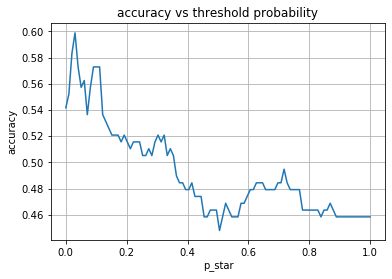

In [83]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1, num = 100), acc)

ax.set(xlabel='p_star', ylabel='accuracy',
       title='accuracy vs threshold probability')
ax.grid()

plt.show()

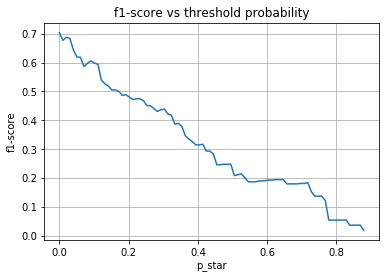

In [84]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1, num = 100), f1)

ax.set(xlabel='p_star', ylabel='f1-score',
       title='f1-score vs threshold probability')
ax.grid()

plt.show()

In [91]:
p_star_best = np.linspace(0,1, num = 100)[np.argmax(acc)]
predictions_pstar = [int(value>p_star_best) for value in y_prob]
accuracy = accuracy_score(y_test, predictions_pstar)
print("best threshold =", p_star_best)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 59.90%


In [92]:
confusion_matrix(y_test, predictions_pstar)

array([[32, 56],
       [21, 83]])

In [93]:
print("Precision:",metrics.precision_score(y_test, predictions_pstar))
print("Recall:",metrics.recall_score(y_test, predictions_pstar))
print("f1-score:",2*metrics.precision_score(y_test, predictions_pstar)*metrics.recall_score(y_test, predictions_pstar)
      /(metrics.precision_score(y_test, predictions_pstar)+metrics.recall_score(y_test, predictions_pstar)))

Precision: 0.5971223021582733
Recall: 0.7980769230769231
f1-score: 0.6831275720164609


#### After fine-tuning our best model (XGBoost classifier) to adjust threshold probability for the real data,
#### we got an accuracy of 59.9% and an f1-score of 0.68 on the real images.